In [1]:
import pandas as pd
from pathlib import Path
import torch
import sys
import pandas as pd
import numpy as np
sys.path.append('src')

from models.ae_kan import KANAutoencoder
from src.utils.new_preprocessing import preprocessing_dataset

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Total memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")
    print(f"Memory available: {torch.cuda.mem_get_info()[0] / 1024**3:.1f} GB")

print(f"Device : {device}")


GPU: NVIDIA GeForce RTX 3070 Laptop GPU
Total memory: 8.0 GB
Memory available: 6.9 GB
Device : cuda


# Datasets import

In [2]:
data_dir = Path("data/processed/sectors")
sectors_list = [d.name for d in data_dir.iterdir() if d.is_dir() and d.name != 'unknown']

sector_log_returns = {}
for sector in sectors_list:
    returns_path = data_dir / sector / "log_returns.csv"
    df = pd.read_csv(returns_path, index_col=0)
    sector_log_returns[sector] = df.iloc[1:]  # Skip first row with NaN values

In [3]:
X_df = {}
W_df = {}
M_df = {}
data = {}

for sector in sector_log_returns:
    # Preprocess data for each sector
    X_df[sector], W_df[sector], M_df[sector] = preprocessing_dataset(
        log_returns_df=sector_log_returns[sector],
        win=60,
        min_periods=40,
        clip_val=3.0,
        min_valid_per_day=5,
        use_median=True,
        soft_weights=True
    )
    
    # Create tensors for each sector
    tensors = {
        'X': torch.tensor(X_df[sector].values, dtype=torch.float32),
        'W': torch.tensor(W_df[sector].values, dtype=torch.float32),
        'M': torch.tensor(M_df[sector].values, dtype=torch.float32)
    }

    # Split into train/test for each sector
    train_size = int(0.8 * len(tensors['X']))
    data[sector] = {
        'train': {
            'X': tensors['X'][:train_size],
            'W': tensors['W'][:train_size],
            'M': tensors['M'][:train_size]
        },
        'test': {
            'X': tensors['X'][train_size:],
            'W': tensors['W'][train_size:],
            'M': tensors['M'][train_size:]
        }
    }

print(f"\nSector: {sector}")
print(f"Train: {data[sector]['train']['X'].shape[0]} échantillons")
print(f"Test: {data[sector]['test']['X'].shape[0]} échantillons") 
print(f"Dates train: {X_df[sector].index[0]} à {X_df[sector].index[train_size-1]}")
print(f"Dates test: {X_df[sector].index[train_size]} à {X_df[sector].index[-1]}")


Sector: utilities
Train: 2987 échantillons
Test: 747 échantillons
Dates train: 2010-03-03 à 2022-01-10
Dates test: 2022-01-11 à 2024-12-31


In [4]:
data["utilities"]["train"]["X"]

tensor([[ 0.7095, -0.2273,  1.4788,  ...,  0.6971, -0.0319,  0.1895],
        [ 0.5891, -0.2844, -0.7470,  ..., -0.0982, -0.4259, -0.9280],
        [ 0.3553,  0.0000,  0.2215,  ...,  0.7744, -0.5840, -0.4092],
        ...,
        [-0.0682,  0.0000,  0.2831,  ...,  0.9535, -0.1712, -0.3092],
        [-0.2909,  1.1647, -0.8697,  ...,  0.6001,  0.0765,  0.1190],
        [-0.4511, -0.1024,  0.0603,  ..., -0.0457,  0.0000,  1.2413]])

# Generate hyperparameters grid

In [5]:
# def generate_grid_for_sector(X_df, sector):
#     hyperparameters_grid = {
#     'input_dim': X_df[sector].shape[1],
#     'hidden_dims_choices': [
#         [128, 64],
#         [256, 128, 64], 
#         [512, 256, 128, 64]
#     ],
#     'latent_dims': [8, 16, 32], # bottleneck

#     # Architecture KAN
#     'basis_types': ["spline", "poly"],
#     'M_values': [8, 16, 32],
#     'poly_degrees': [3, 5, 7],

#     # Activation et régularisation
#     'use_silu_choices': [True, False],  # SiLU vs Identity
#     'dropout_rates': [0.0, 0.1, 0.2],

#     # Skip connections
#     'use_global_skip': [True, False],
#     'use_skip_choices': [True, False],  # Skip par couche
#     'skip_init_choices': ["zeros", "identity", "xavier"],
#     'skip_gain_values': [0.1, 0.5, 1.0],

#     # Régularisations
#     'lambda_reg_values': [0.0, 1e-4, 1e-3],
#     'lambda_alpha_values': [0.0, 1e-4, 1e-3],  # L1 sur alpha
#     'lambda_group_values': [0.0, 1e-5, 1e-4],  # Group lasso sur c
#     'lambda_tv_values': [0.0, 1e-4, 1e-3],  # Total variation sur c (splines)
#     'lambda_poly_decay_values': [0.0, 0.1, 1.0],  # Décroissance polynomiale (poly)
#     'lambda_skip_l2_values': [0.0, 1e-3, 1e-2],  # L2 sur skip

#     # Loss
#     'loss_types': ["mse", "huber"], 
#     'huber_deltas': [0.1, 0.5, 1.0],

#     # Optimisation du training
#     'learning_rates': [1e-4, 5e-4, 1e-3],
#     'weight_decays': [1e-5, 1e-4],
#     'batch_sizes': [32, 64, 128, 256]
# }
#     return hyperparameters_grid


In [6]:
def create_hyperparams_grid(input_dim):
    hyperparameters = {
        'input_dim': input_dim,
        'hidden_dims_choices': [[64, 32], [32], [32, 16]],
        'latent_dims': [5, 8, 12, 20],
        'basis_types': 'spline',
        'M_values': [8, 16, 32],
        'poly_degrees': [3, 5, 7],
        'use_silu_choices': True,
        'dropout_rates': 0.1,
        
        'use_global_skip': True,
        'use_skip_choices': False,
        'skip_init_choices': ['zeros', 'identity', 'xavier'],
        'skip_gain_values': [0.1, 0.5, 1.0],
        'max_skip_gain': [0.3, 0.5, 0.7, 0.9],
        
        'lambda_alpha_values': [1e-3, 1e-4, 1e-5],
        'lambda_group_values': [1e-4, 1e-5, 1e-6],
        'lambda_tv_values': [5e-4, 1e-4, 1e-5],
        'lambda_poly_decay_values': [1e-4, 1e-5, 1e-6],
        'lambda_skip_l2_values': [1e-5, 1e-6, 1e-7],
        
        'loss_types': 'huber',
        'huber_deltas': [1.0, 0.5],
        
        'batch_sizes': [32, 64, 128],
        'learning_rates': [1e-3, 1e-4, 1e-5],
        'weight_decays': [1e-5, 1e-6, 1e-7],
        'lambda_reg_values': [1e-2, 1e-3, 1e-4]
    }
    # Sample one value randomly from each hyperparameter list
    sampled_params = {}
    for param_name, param_values in hyperparameters.items():
        if isinstance(param_values, (list, tuple)):
            if isinstance(param_values[0], list):
                # Handle nested lists like hidden_dims_choices
                sampled_params[param_name] = param_values[np.random.randint(len(param_values))]
            else:
                # Handle flat lists
                sampled_params[param_name] = np.random.choice(param_values)
        else:
            sampled_params[param_name] = param_values
            
    return sampled_params

In [7]:
from src.utils.new_preprocessing import plot_training_history
import json
import time
from datetime import datetime
from pathlib import Path

def simple_train_kan(sector_name, sector_data, hyperparams, epochs=100, save_results=True, plot_results=True, save_here=None):
    print(f"🚀 Entraînement simple pour le secteur: {sector_name}")
    
    X_train = sector_data['train']['X']
    X_test = sector_data['test']['X']
    input_dim = X_train.shape[1]
    
    print(f"📊 Dimensions: Train {X_train.shape}, Test {X_test.shape}")
    
    # Générer la grille d'hyperparamètres
    # sampled_params = create_hyperparams_grid(input_dim)
    
    print()
    print(f"   - Architecture: {input_dim} → {hyperparams['hidden_dims_choices']} → {hyperparams['latent_dims']}")
    print(f"   - Basis: {hyperparams['basis_types']}, M: {hyperparams['M_values']}")
    print(f"   - Learning rate: {hyperparams['learning_rates']:.1e}")
    print(f"   - Batch size: {hyperparams['batch_sizes']}")
    print(f"   - Dropout: {hyperparams['dropout_rates']}")
    print(f"   - Use SiLU: {hyperparams['use_silu_choices']}")
    print(f"   - Skip connections: {hyperparams['use_skip_choices']}")
    print(f"   - Skip init: {hyperparams['skip_init_choices']}")
    print(f"   - Skip gain: {hyperparams['skip_gain_values']}")
    print(f"   - Max skip gain: {hyperparams['max_skip_gain']}")
    print(f"   - Global skip: {hyperparams['use_global_skip']}")
    print(f"   - Loss type: {hyperparams['loss_types']}")
    print(f"   - Huber delta: {hyperparams['huber_deltas']}")
    print(f"   - Weight decay: {hyperparams['weight_decays']}")
    print(f"   - Lambda reg: {hyperparams['lambda_reg_values']}")
    print(f"   - Lambda alpha: {hyperparams['lambda_alpha_values']}")
    print(f"   - Lambda group: {hyperparams['lambda_group_values']}")
    print(f"   - Lambda TV: {hyperparams['lambda_tv_values']}")
    print(f"   - Lambda poly decay: {hyperparams['lambda_poly_decay_values']}")
    print(f"   - Lambda skip L2: {hyperparams['lambda_skip_l2_values']}")
    print(f"   - Poly degree: {hyperparams['poly_degrees']}")
    print()
    
    # Entraîner le modèle
    start_time = time.time()
    
    try:
        model = KANAutoencoder(
            input_dim=input_dim,
            hidden_dims=hyperparams['hidden_dims_choices'],
            k=hyperparams['latent_dims'],
            basis_type=hyperparams['basis_types'],
            M=hyperparams['M_values'],
            poly_degree=hyperparams['poly_degrees'],
            use_silu=hyperparams['use_silu_choices'],
            dropout_p=hyperparams['dropout_rates'],
            use_global_skip=hyperparams['use_global_skip'],
            use_skip=hyperparams['use_skip_choices'],
            skip_init=hyperparams['skip_init_choices'],
            skip_gain=hyperparams['skip_gain_values'],
            max_skip_gain=hyperparams['max_skip_gain'],
            lambda_alpha=hyperparams['lambda_alpha_values'],
            lambda_group=hyperparams['lambda_group_values'],
            lambda_tv=hyperparams['lambda_tv_values'],
            lambda_poly_decay=hyperparams['lambda_poly_decay_values'],
            lambda_skip_l2=hyperparams['lambda_skip_l2_values'],
            loss_type=hyperparams['loss_types'],
            huber_delta=hyperparams['huber_deltas']
        ).to(device)
        
        # Entraînement
        history = model.fit(
            X=X_train,
            epochs=epochs,
            batch_size=int(hyperparams['batch_sizes']),
            learning_rate=float(hyperparams['learning_rates']),
            weight_decay=float(hyperparams['weight_decays']),
            validation_split=0.2,
            patience=15,
            verbose=True,
            lambda_reg=float(hyperparams['lambda_reg_values']),
            device=device
        )
        
        training_time = time.time() - start_time
        
        # Évaluation sur le test
        model.eval()
        with torch.no_grad():
            X_test_recon, latent_test = model(X_test.to(device))
            test_criterion = model.get_loss_criterion()
            test_loss = test_criterion(X_test_recon, X_test.to(device)).item()
            
            # Métriques supplémentaires
            mse_loss = torch.nn.MSELoss()(X_test_recon, X_test.to(device)).item()
            mae_loss = torch.nn.L1Loss()(X_test_recon, X_test.to(device)).item()
        
        print(f"✅ Entraînement terminé en {training_time:.1f}s")
        print(f"📊 Test Loss: {test_loss:.6f}")
        print(f"📏 MSE: {mse_loss:.6f}, MAE: {mae_loss:.6f}")
        
        # Visualiser les résultats si demandé
        if plot_results:
            plot_training_history(history, hyperparams)
        
        # Préparer les résultats
        results = {
            'sector': sector_name,
            'timestamp': datetime.now().strftime("%Y%m%d_%H%M%S"),
            'hyperparameters': hyperparams,
            'history': history,
            'test_loss': test_loss,
            'mse_loss': mse_loss,
            'mae_loss': mae_loss,
            'training_time': training_time,
            'epochs_trained': len(history['train_loss']),
            'best_val_loss': min(history['val_loss']) if history['val_loss'] else None,
            'final_skip_gain': history['skip_gain'][-1] if history['skip_gain'] else None,
            'model_state': model.state_dict()
        }
        
        # Sauvegarder les résultats si demandé
        if save_results:
            results_dir = Path(save_here) if save_here is not None else Path('results')
            results_dir.mkdir(exist_ok=True)
            
            # Sauvegarder sans le model_state (trop lourd pour JSON)
            results_to_save = {k: v for k, v in results.items() if k != 'model_state'}
            
            filename = f"simple_kan_training_{sector_name}_{results['timestamp']}.json"
            filepath = results_dir / filename
            
            with open(filepath, 'w') as f:
                json.dump(results_to_save, f, indent=2, default=str)
            
            print(f"💾 Résultats sauvegardés: {filepath}")
        
        return results
        
    except Exception as e:
        print(f"❌ Erreur durant l'entraînement: {str(e)}")
        return None


# Exemples d'utilisation des fonctions d'entraînement


In [8]:
hyperparams = {
    'hidden_dims_choices': [32, 16],
    'latent_dims': 8,
    
    # BASIS
    'basis_types': 'spline',
    'M_values': 16,
    'poly_degrees': 3,
    'use_silu_choices': True,
    'dropout_rates': 0,
    
    # SKIP LINEAIRE
    'use_global_skip': True,
    'use_skip_choices': False,
    'skip_init_choices': 'identity',
    'skip_gain_values': 0.1,
    'max_skip_gain': 0.3,
    
    # REGULARISATION
    'lambda_alpha_values': 1e-3,
    'lambda_group_values': 1e-4,
    'lambda_tv_values': 1e-5,
    'lambda_poly_decay_values': 1e-6,
    'lambda_skip_l2_values': 1e-3,
    'lambda_reg_values': 1e-4,
    
    # LOSS
    'loss_types': 'huber',
    'huber_deltas': 1.0,
    
    # OPTIMISATION
    'batch_sizes': 64,
    'learning_rates': 0.0002,
    'weight_decays': 0.000001
}

🚀 Entraînement simple pour le secteur: communication_services
📊 Dimensions: Train torch.Size([2987, 17]), Test torch.Size([747, 17])

   - Architecture: 17 → [32, 16] → 8
   - Basis: spline, M: 16
   - Learning rate: 2.0e-04
   - Batch size: 64
   - Dropout: 0
   - Use SiLU: True
   - Skip connections: False
   - Skip init: identity
   - Skip gain: 0.1
   - Max skip gain: 0.3
   - Global skip: True
   - Loss type: huber
   - Huber delta: 1.0
   - Weight decay: 1e-06
   - Lambda reg: 0.0001
   - Lambda alpha: 0.001
   - Lambda group: 0.0001
   - Lambda TV: 1e-05
   - Lambda poly decay: 1e-06
   - Lambda skip L2: 0.001
   - Poly degree: 3



📈 Epoch 1/10 | Train: 0.208662 | Val: 0.216559 ✅ | Reg: 0.042829 | LR: 2.00e-04
   ↳ skip_gain=0.1076 | ||W_skip||=4.1550
📈 Epoch 2/10 | Train: 0.205680 | Val: 0.212537 ✅ | Reg: 0.030522 | LR: 2.00e-04
   ↳ skip_gain=0.1153 | ||W_skip||=4.1889
📈 Epoch 3/10 | Train: 0.201207 | Val: 0.208399 ✅ | Reg: 0.026933 | LR: 2.00e-04
   ↳ skip_gain=0.1229 | ||W_skip||=4.2250
📈 Epoch 4/10 | Train: 0.197543 | Val: 0.204174 ✅ | Reg: 0.025586 | LR: 2.00e-04
   ↳ skip_gain=0.1306 | ||W_skip||=4.2631
📈 Epoch 5/10 | Train: 0.193287 | Val: 0.199812 ✅ | Reg: 0.025029 | LR: 2.00e-04
   ↳ skip_gain=0.1384 | ||W_skip||=4.3035
📈 Epoch 6/10 | Train: 0.188837 | Val: 0.195391 ✅ | Reg: 0.025059 | LR: 2.00e-04
   ↳ skip_gain=0.1461 | ||W_skip||=4.3455
📈 Epoch 7/10 | Train: 0.184576 | Val: 0.190814 ✅ | Reg: 0.025340 | LR: 2.00e-04
   ↳ skip_gain=0.1540 | ||W_skip||=4.3897
📈 Epoch 8/10 | Train: 0.180357 | Val: 0.186195 ✅ | Reg: 0.025700 | LR: 2.00e-04
   ↳ skip_gain=0.1618 | ||W_skip||=4.4354
📈 Epoch 9/10 | Train: 0.

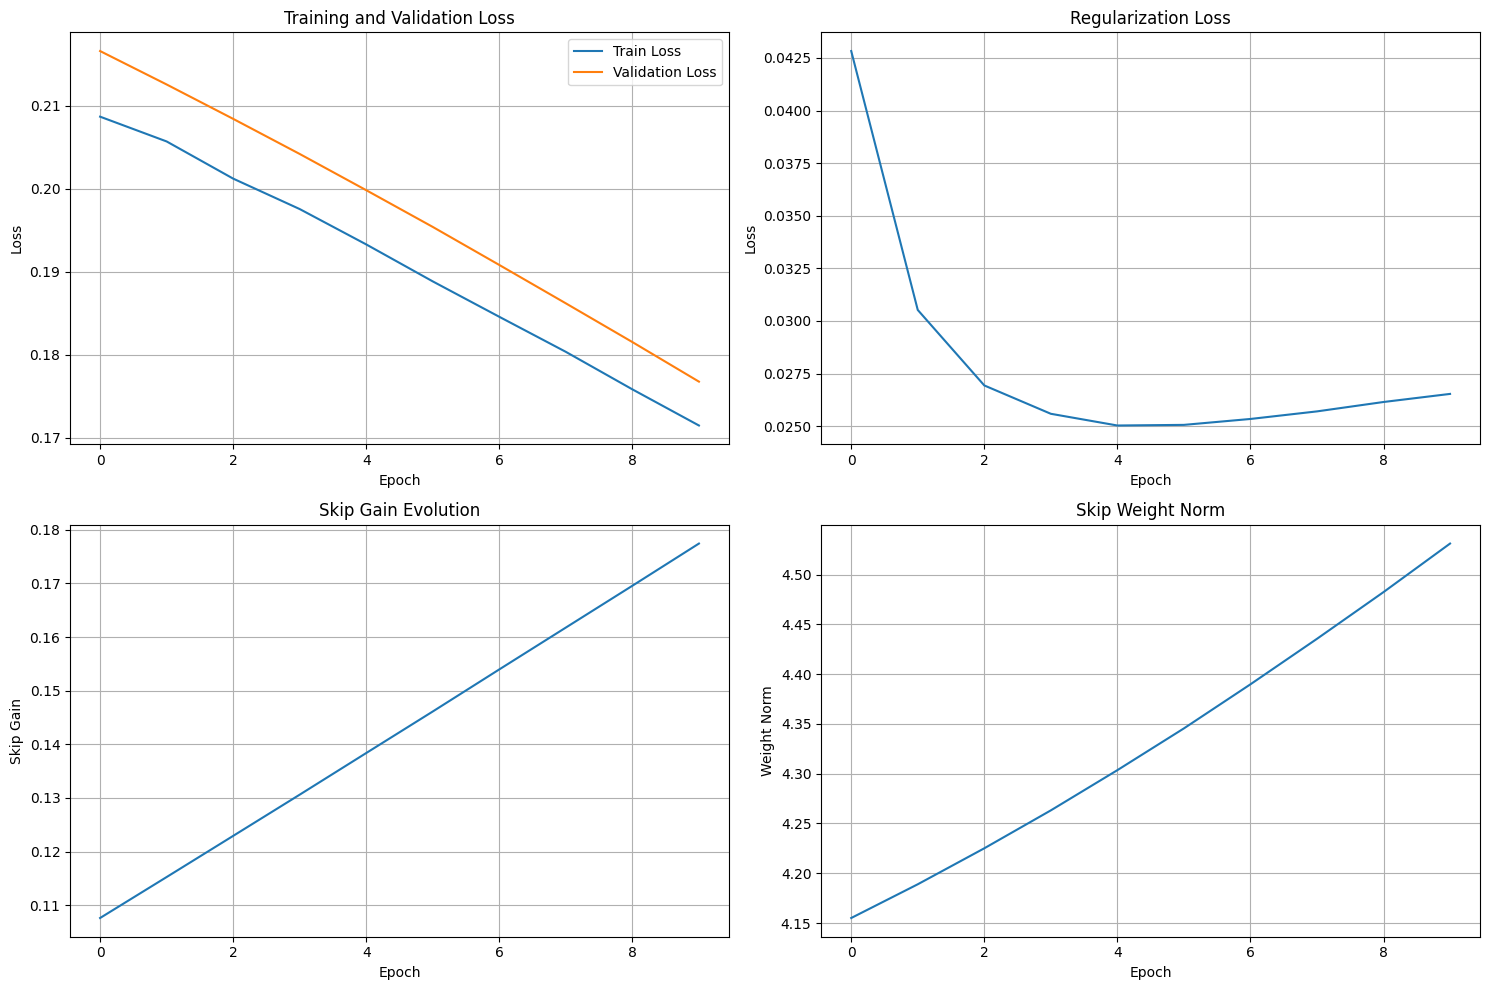

🚀 Entraînement simple pour le secteur: consumer_discretionary
📊 Dimensions: Train torch.Size([2987, 43]), Test torch.Size([747, 43])

   - Architecture: 43 → [32, 16] → 8
   - Basis: spline, M: 16
   - Learning rate: 2.0e-04
   - Batch size: 64
   - Dropout: 0
   - Use SiLU: True
   - Skip connections: False
   - Skip init: identity
   - Skip gain: 0.1
   - Max skip gain: 0.3
   - Global skip: True
   - Loss type: huber
   - Huber delta: 1.0
   - Weight decay: 1e-06
   - Lambda reg: 0.0001
   - Lambda alpha: 0.001
   - Lambda group: 0.0001
   - Lambda TV: 1e-05
   - Lambda poly decay: 1e-06
   - Lambda skip L2: 0.001
   - Poly degree: 3

📈 Epoch 1/10 | Train: 0.204482 | Val: 0.200760 ✅ | Reg: 0.090441 | LR: 2.00e-04
   ↳ skip_gain=0.1076 | ||W_skip||=6.6087
📈 Epoch 2/10 | Train: 0.199844 | Val: 0.196815 ✅ | Reg: 0.070884 | LR: 2.00e-04
   ↳ skip_gain=0.1153 | ||W_skip||=6.6646
📈 Epoch 3/10 | Train: 0.196759 | Val: 0.192749 ✅ | Reg: 0.065091 | LR: 2.00e-04
   ↳ skip_gain=0.1230 | ||W_sk

KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

In [ ]:
for sector in sectors_list:
    simple_train_kan(sector, data[sector], hyperparams, epochs=200, save_results=True, plot_results=True, save_here="results/test4")

# Test 2

In [ ]:
hyperparams = {
    'hidden_dims_choices': [32, 16],
    'latent_dims': 8,
    
    # BASIS
    'basis_types': 'spline',
    'M_values': 16,
    'poly_degrees': 3,
    'use_silu_choices': True,
    'dropout_rates': 0,
    
    # SKIP LINEAIRE
    'use_global_skip': True,
    'use_skip_choices': False,
    'skip_init_choices': 'identity',
    'skip_gain_values': 0.7,
    'max_skip_gain': 0.5,
    
    # REGULARISATION
    'lambda_alpha_values': 1e-3,
    'lambda_group_values': 1e-4,
    'lambda_tv_values': 1e-5,
    'lambda_poly_decay_values': 1e-6,
    'lambda_skip_l2_values': 1e-3,
    'lambda_reg_values': 1e-4,
    
    # LOSS
    'loss_types': 'huber',
    'huber_deltas': 1.0,
    
    # OPTIMISATION
    'batch_sizes': 64,
    'learning_rates': 0.0002,
    'weight_decays': 0.000001
}

In [ ]:
for sector in sectors_list:
    simple_train_kan(sector, data[sector], hyperparams, epochs=200, save_results=True, plot_results=True, save_here="results/test4")

# Test 3

In [ ]:
hyperparams = {
    'hidden_dims_choices': [32, 16],
    'latent_dims': 8,
    
    # BASIS
    'basis_types': 'spline',
    'M_values': 16,
    'poly_degrees': 3,
    'use_silu_choices': True,
    'dropout_rates': 0,
    
    # SKIP LINEAIRE
    'use_global_skip': True,
    'use_skip_choices': False,
    'skip_init_choices': 'zeros',
    'skip_gain_values': 0.3,
    'max_skip_gain': 0.7,
    
    # REGULARISATION
    'lambda_alpha_values': 1e-3,
    'lambda_group_values': 1e-4,
    'lambda_tv_values': 1e-5,
    'lambda_poly_decay_values': 1e-6,
    'lambda_skip_l2_values': 1e-3,
    'lambda_reg_values': 1e-4,
    
    # LOSS
    'loss_types': 'huber',
    'huber_deltas': 1.0,
    
    # OPTIMISATION
    'batch_sizes': 64,
    'learning_rates': 0.0002,
    'weight_decays': 0.000001
}

In [ ]:
for sector in sectors_list:
    simple_train_kan(sector, data[sector], hyperparams, epochs=200, save_results=True, plot_results=True, save_here="results/test4")

# Test 4

In [ ]:
hyperparams = {
    'hidden_dims_choices': [32, 16],
    'latent_dims': 8,
    
    # BASIS
    'basis_types': 'spline',
    'M_values': 16,
    'poly_degrees': 3,
    'use_silu_choices': True,
    'dropout_rates': 0,
    
    # SKIP LINEAIRE
    'use_global_skip': True,
    'use_skip_choices': False,
    'skip_init_choices': 'xavier',
    'skip_gain_values': 0.3,
    'max_skip_gain': 0.7,
    
    # REGULARISATION
    'lambda_alpha_values': 1e-3,
    'lambda_group_values': 1e-4,
    'lambda_tv_values': 1e-5,
    'lambda_poly_decay_values': 1e-6,
    'lambda_skip_l2_values': 1e-3,
    'lambda_reg_values': 1e-4,
    
    # LOSS
    'loss_types': 'huber',
    'huber_deltas': 1.0,
    
    # OPTIMISATION
    'batch_sizes': 64,
    'learning_rates': 0.0002,
    'weight_decays': 0.000001
}

In [ ]:
for sector in sectors_list:
    simple_train_kan(sector, data[sector], hyperparams, epochs=200, save_results=True, plot_results=True, save_here="results/test4")

# Test 5

In [ ]:
hyperparams = {
    'hidden_dims_choices': [32, 16],
    'latent_dims': 8,
    
    # BASIS
    'basis_types': 'spline',
    'M_values': 16,
    'poly_degrees': 3,
    'use_silu_choices': True,
    'dropout_rates': 0,
    
    # SKIP LINEAIRE
    'use_global_skip': True,
    'use_skip_choices': False,
    'skip_init_choices': 'zeros',
    'skip_gain_values': 0.1,
    'max_skip_gain': 0.5,
    
    # REGULARISATION
    'lambda_alpha_values': 1e-3,
    'lambda_group_values': 1e-4,
    'lambda_tv_values': 1e-5,
    'lambda_poly_decay_values': 1e-6,
    'lambda_skip_l2_values': 1e-3,
    'lambda_reg_values': 1e-4,
    
    # LOSS
    'loss_types': 'huber',
    'huber_deltas': 1.0,
    
    # OPTIMISATION
    'batch_sizes': 64,
    'learning_rates': 0.0002,
    'weight_decays': 0.000001
}

In [ ]:
for sector in sectors_list:
    simple_train_kan(sector, data[sector], hyperparams, epochs=200, save_results=True, plot_results=True, save_here="results/test4")